In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from functools import partial
import tensorflow_datasets as tfds
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate)
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()


In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [4]:
train_images = train_images / 255.0

test_images = test_images / 255.0


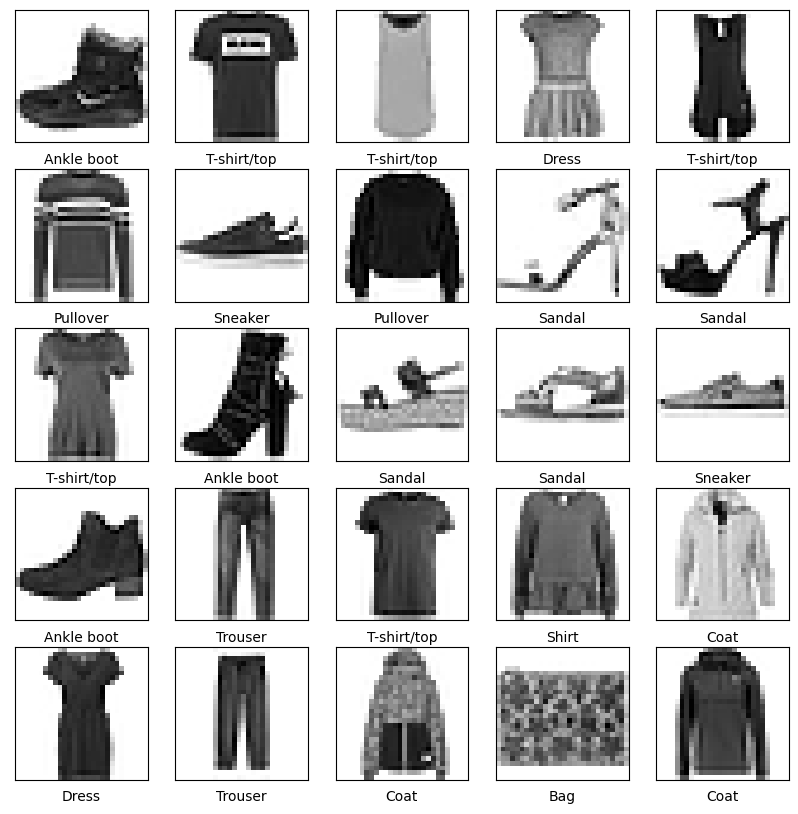

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [6]:
X_train, X_test, y_train, y_test = \
    train_test_split(train_images, train_labels, test_size=0.1, random_state=10, stratify=train_labels)

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [8]:
def exponential_decay_fn(epoch, current_lr):
  return current_lr * 0.2**(epoch / 10)

In [9]:
adam_optim = tf.keras.optimizers.Adam(learning_rate=0.001, decay=exponential_decay_fn(30, 0.001))

In [10]:
model.compile(optimizer=adam_optim,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [11]:
EPOCHS = 30
checkpoint_filepath = './tmp2/checkpoint/'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [12]:
train_history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, batch_size=128, callbacks=[model_checkpoint_callback])

#!mkdir -p saved_model
#model.save('saved_model/my_model')


Epoch 1/30
338/338 [==============================] - 2s 6ms/step - loss: 0.5482 - accuracy: 0.8074 - val_loss: 0.3958 - val_accuracy: 0.8600
Epoch 2/30
338/338 [==============================] - 2s 5ms/step - loss: 0.3961 - accuracy: 0.8565 - val_loss: 0.3713 - val_accuracy: 0.8669
Epoch 3/30
338/338 [==============================] - 1s 4ms/step - loss: 0.3474 - accuracy: 0.8725 - val_loss: 0.3486 - val_accuracy: 0.8719
Epoch 4/30
338/338 [==============================] - 2s 5ms/step - loss: 0.3224 - accuracy: 0.8808 - val_loss: 0.3250 - val_accuracy: 0.8804
Epoch 5/30
338/338 [==============================] - 1s 3ms/step - loss: 0.3029 - accuracy: 0.8871 - val_loss: 0.3577 - val_accuracy: 0.8711
Epoch 6/30
338/338 [==============================] - 2s 5ms/step - loss: 0.2863 - accuracy: 0.8937 - val_loss: 0.3096 - val_accuracy: 0.8870
Epoch 7/30
338/338 [==============================] - 1s 3ms/step - loss: 0.2710 - accuracy: 0.8978 - val_loss: 0.3414 - val_accuracy: 0.8708
Epoch 

In [13]:
os.listdir(checkpoint_filepath)

['.data-00000-of-00001', '.index', 'checkpoint']

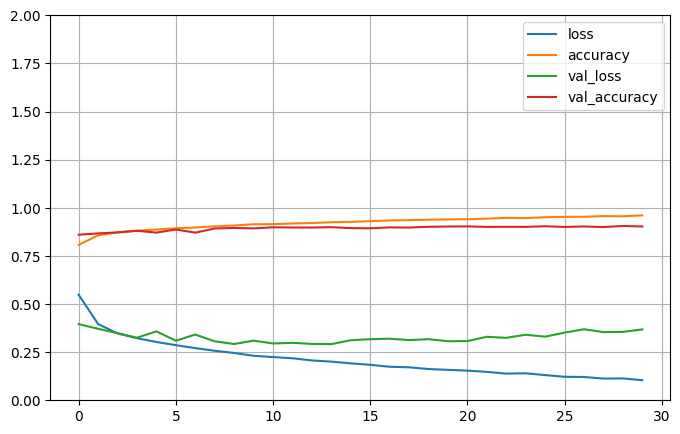

In [14]:
pd.DataFrame(train_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [15]:
model.load_weights(checkpoint_filepath)

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

188/188 - 0s - loss: 0.3765 - accuracy: 0.8987 - 195ms/epoch - 1ms/step

Test accuracy: 0.8986666798591614


In [17]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


In [18]:
def weryfikacja(nr):
    predictions = model.predict(X_test)
    
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(nr, predictions[nr], y_test, X_test)
    plt.subplot(1,2,2)
    plot_value_array(nr, predictions[nr],  y_test)
    plt.show()


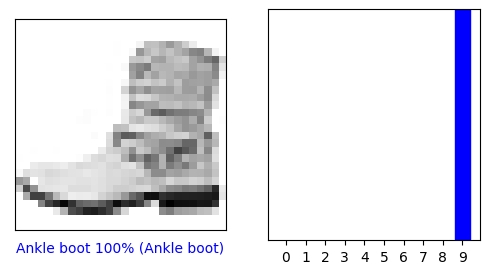

In [19]:
weryfikacja(3)

# Rozwiązanie z augmentacją

In [22]:
transforms = Compose([
            RandomBrightness(limit=0.1),
            RandomContrast(limit=0.2, p=0.5),
            HorizontalFlip()
        ])

In [23]:
def augment_train(data):
    return transforms(image=data)['image']

zbior1=augment_train(train_images)
zbior1.shape

(60000, 28, 28)

In [24]:
train_images_aug = np.concatenate((train_images, zbior1), axis=0)
train_images_aug.shape

(120000, 28, 28)

In [25]:
train_labels_ext = np.concatenate((train_labels, train_labels), axis=0)
train_labels_ext.shape

(120000,)

In [26]:
train_images_aug = train_images_aug / 255.0

In [27]:
X_train2, X_test2, y_train2, y_test2 = \
    train_test_split(train_images_aug, train_labels_ext, test_size=0.1, random_state=10, stratify=train_labels_ext)

In [28]:
EPOCHS = 30
checkpoint_filepath2 = './tmp3/checkpoint/'

model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [29]:
train_history2 = model.fit(X_train2, y_train2, epochs=EPOCHS, validation_split=0.2, batch_size=128, callbacks=[model_checkpoint_callback2])

Epoch 1/30
675/675 [==============================] - 3s 5ms/step - loss: 1.0473 - accuracy: 0.6673 - val_loss: 0.6819 - val_accuracy: 0.7515
Epoch 2/30
675/675 [==============================] - 3s 4ms/step - loss: 0.6105 - accuracy: 0.7785 - val_loss: 0.5798 - val_accuracy: 0.7918
Epoch 3/30
675/675 [==============================] - 3s 5ms/step - loss: 0.5342 - accuracy: 0.8080 - val_loss: 0.5000 - val_accuracy: 0.8214
Epoch 4/30
675/675 [==============================] - 3s 4ms/step - loss: 0.4911 - accuracy: 0.8241 - val_loss: 0.4680 - val_accuracy: 0.8301
Epoch 5/30
675/675 [==============================] - 3s 5ms/step - loss: 0.4619 - accuracy: 0.8343 - val_loss: 0.4524 - val_accuracy: 0.8340
Epoch 6/30
675/675 [==============================] - 3s 4ms/step - loss: 0.4373 - accuracy: 0.8437 - val_loss: 0.4284 - val_accuracy: 0.8467
Epoch 7/30
675/675 [==============================] - 3s 4ms/step - loss: 0.4208 - accuracy: 0.8496 - val_loss: 0.4106 - val_accuracy: 0.8519
Epoch 

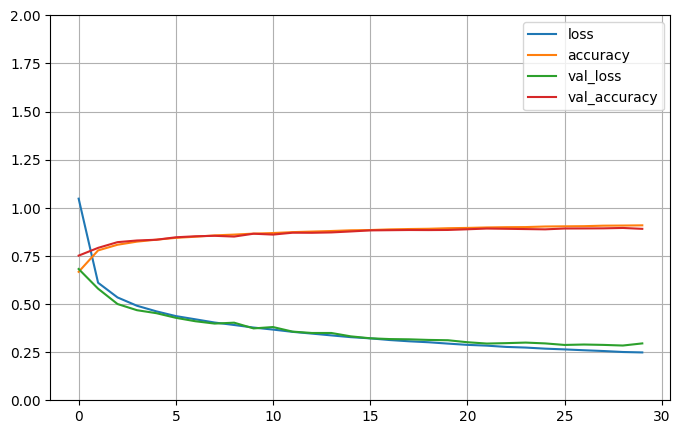

In [30]:
pd.DataFrame(train_history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [31]:
model.load_weights(checkpoint_filepath2)

In [32]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

188/188 - 0s - loss: 45.4196 - accuracy: 0.6540 - 207ms/epoch - 1ms/step

Test accuracy: 0.6539999842643738
